# **AT1- Kaggle Competition Week 3: Advance MLA - Part B**
## Balancing the data (as we have very less samples for target 1)
Experiment: Perform Upsampling techniques to balance the dataset from Part A experiment and compare the AUCROC score to pick the best model.



## 1. Load and Explore Dataset



**[1.1]** Launch magic commands to automatically reload modules

In [1]:
%load_ext autoreload
%autoreload 2

**[1.2]** Import the pandas and numpy package

In [2]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**[1.3]** Load the interim dataset from part A

In [3]:
df_train_clean = pd.read_csv('../data/interim/df_train_cleaned.csv')

In [4]:
# Reading processed test data into df_test
df_test_clean = pd.read_csv('../data/interim/df_test_cleaned.csv')

In [5]:
# Count the number of target value
df_train_clean['drafted'].value_counts()

0.0    23753
1.0      176
Name: drafted, dtype: int64

**[1.4]** Extract the column `drafted` and save it into variable called `target`

In [7]:
target = df_train_clean.pop('drafted')

## 2. Feature Engineering

**[2.1]** Perform Upsampling using SMOTE

In [9]:
# Importing SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Resampling the minority class.
sm = SMOTE(sampling_strategy='minority', random_state=23)

# Fit the model to generate the data.
X_oversampled, y_oversampled = sm.fit_resample(df_train_clean, target)

**[2.2]** Check shape before and after upsampling

In [11]:
print(df_train_clean.shape, X_oversampled.shape)
print(target.shape, y_oversampled.shape)

(23929, 57) (47506, 57)
(23929,) (47506,)


<Axes: xlabel='drafted', ylabel='count'>

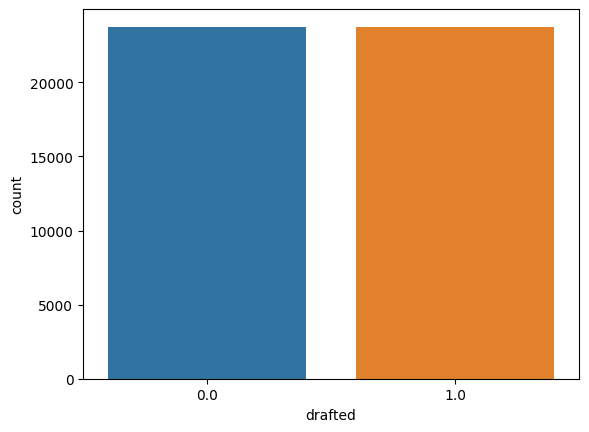

In [12]:
# Distribution of target variable after balancing data
df = pd.concat([X_oversampled,y_oversampled], axis=1)
sns.countplot(x='drafted', data=df)

## 3. Scale data

**[3.1]** Create a list named `num_cols` containing the names of numerical columns

In [13]:
num_cols = list(X_oversampled.select_dtypes('number').columns)

**[3.2]** Import StandardScaler from sklearn.preprocessing

In [14]:
from sklearn.preprocessing import StandardScaler

**[3.3]** Instantiate the StandardScaler.

In [15]:
scaler = StandardScaler()

**[3.4]** Fit and apply the scaling on `X_oversampled`

In [16]:
X_oversampled[num_cols] = scaler.fit_transform(X_oversampled[num_cols])

In [17]:
df_test_clean[num_cols] = scaler.transform(df_test_clean[num_cols])

In [18]:
from joblib import dump

**[3.5]** Save the scaler into the folder `models` as `scaler.joblib`

In [31]:
dump(scaler, '../models/scaler_w3b.joblib')

['../models/scaler_w3b.joblib']

## 4. Split Dataset

**[4.1]** import train_test_split from sklearn.model_selection

In [19]:
from sklearn.model_selection import train_test_split

**[4.2]** Split the train data into training & validation. Split the data to create unbiased splits with the number ratio of 1's and 0's in the target

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
                                            X_oversampled, y_oversampled, \
                                            test_size=0.3, random_state=23, \
                                            stratify = y_oversampled, shuffle = True)

**[4.3]** Print the dimensions of `X_train`, `X_val`, `X_test`

In [21]:
print(X_train.shape)
print(X_val.shape)
print(df_test_clean.shape)

(33254, 57)
(14252, 57)
(4970, 57)


**[4.4]** Print the dimensions of `y_train`, `y_val`

In [22]:
print(y_train.shape)
print(y_val.shape)

(33254,)
(14252,)


**[4.5]** Save the sets into the folder `data/processed`

In [37]:
# make directory to save data files for week 3
%mkdir '../data/processed/week_3b'

In [38]:
X_train.to_csv('../data/processed/week_3b/X_train.csv', index=False)
X_val.to_csv('../data/processed/week_3b/X_val.csv', index=False)
y_train.to_csv('../data/processed/week_3b/y_train.csv', index=False)
y_val.to_csv('../data/processed/week_3b/y_val.csv', index=False)
df_test_clean.to_csv('../data/processed/week_3b/test.csv', index=False)

## 5. Train classifier

**[5.1]** Trained LogisticRegression on train set, the AUCROC score on val set was **0.99769**

**[5.2]** Import RandomForestClassifier from sklearn ensemble models, initiate the class and fit the model

In [26]:
# import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

**[5.3]** Generate probabilities for `X_val` and save it in `y_val_pred_rf`

In [27]:
y_val_pred_rf = rf.predict_proba(X_val)[:,1]
auc_roc_rf = roc_auc_score(y_val, y_val_pred_rf)
print(f"AUC-ROC Score for Random Forest Classifier: {auc_roc_rf}")

AUC-ROC Score for Random Forest Classifier: 0.9999761716629635


### Highest AUC ROC score - 0.9999 is for the Random Forest Classifier after we applied oversampling

In [28]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_rf)

**[5.4]** Import plot_roc_curve from sklearn.metrics

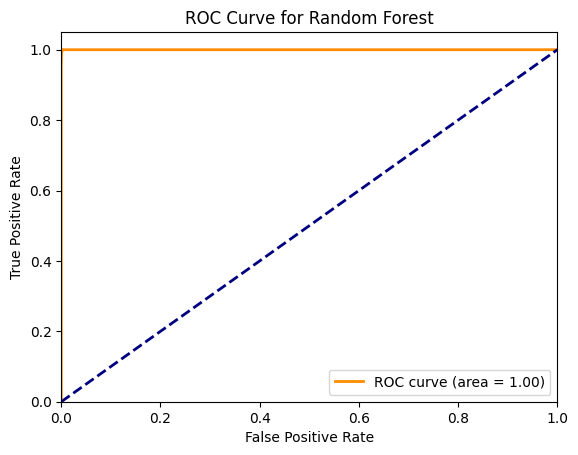

In [29]:
# Plot ROC curve
# source - https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

**[5.5]** Save the Random Forest Classifier model

In [30]:
dump(rf, '../models/rand_forest_week3b.joblib')

['../models/rand_forest_week3b.joblib']

**[5.6]** Copy this model in a separate folder `best_model` to further load it and predict 

In [ ]:
%mkdir '../models/best_model'

In [31]:
%cp '../models/rand_forest_week3b.joblib' '../models/best_model/nba_draft_prediction.joblib'